# Credit Card Fraud Detection

## Loading Packages and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print('Credit card Shape : ', df.shape)

Credit card Shape :  (284807, 31)


In [4]:
def get_preprocessed(df = None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

원본 데이터는 유지하고, Preprocessing을 위해 df_copy를 생성

In [5]:
def get_train_test_dataset(df = None):
    df_copy = get_preprocessed(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_target = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    return X_train, X_test, y_train, y_target

X_train, X_test, y_train, y_test = get_train_test_dataset(df)

stratify = y_target을 지정함으로 y_target(label) 분포에 따라 추출하였음.

In [6]:
print('Proportion of Train data label : \n{}'.format(y_train.value_counts() / y_train.shape[0] * 100))
print()
print('Proportion of Test data label : \n{}'.format(y_test.value_counts() / y_test.shape[0] * 100))

Proportion of Train data label : 
0    99.827451
1     0.172549
Name: Class, dtype: float64

Proportion of Test data label : 
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [7]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix')
    print(confusion)
    
    print('accuracy : {0: .4f}, precision : {1: .4f}, recall : {2: .4f},  F1 : {3: .4f}, AUC : {4: .4f}'.format(accuracy, precision, recall, f1, roc_auc))

<b> Logistic regression </b>

In [8]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

Confusion Matrix
[[85282    13]
 [   57    91]]
accuracy :  0.9992, precision :  0.8750, recall :  0.6149,  F1 :  0.7222, AUC :  0.9570


about Confusion Matrix : https://sumniya.tistory.com/26

In [9]:
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

<b> LightGBM train/ predict/ evaluation </b>

boost_from_average가 True일 때, 레이블 값이 극도로 불균형 분포를 이루는 경우엔 recall 및 roc_auc 성능이 매주 저하된다.

In [10]:
lgbm_clf = LGBMClassifier(n_estimator = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

[LightGBM] [Warning] Unknown parameter: n_estimator
Confusion Matrix
[[85289     6]
 [   38   110]]
accuracy :  0.9995, precision :  0.9483, recall :  0.7432,  F1 :  0.8333, AUC :  0.9717


## Transforming distribution of important features

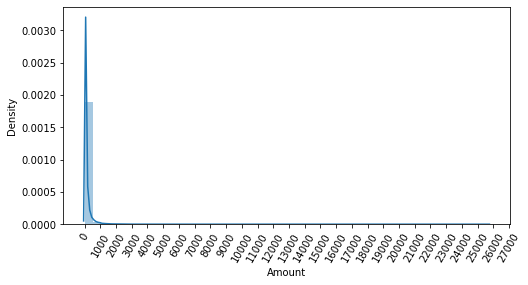

In [11]:
plt.figure(figsize = (8,4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(df['Amount'])
plt.show()

### Standard Scaler

In [12]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount']).values.reshape(-1,1)
    
    # 변환된 Amount를 Amount_scaled로 피처명 변경 , Dataframe 맨 앞 컬럼에 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 amount 피쳐 삭제
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace =True)
    return df_copy

### Evaluation models After Standard Scaling

In [13]:
X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('### Logistic Regression ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print(' ### LightGBM ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves= 64, n_jobs =-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### Logistic Regression ###
Confusion Matrix
[[85282    13]
 [   57    91]]
accuracy :  0.9992, precision :  0.8750, recall :  0.6149,  F1 :  0.7222, AUC :  0.9570
 ### LightGBM ###
Confusion Matrix
[[85290     5]
 [   36   112]]
accuracy :  0.9995, precision :  0.9573, recall :  0.7568,  F1 :  0.8453, AUC :  0.9790


### Log 변환

In [14]:
def get_preprocessed(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

In [15]:
X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('### Logistic Regression ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print(' ### LightGBM ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves= 64, n_jobs =-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### Logistic Regression ###
Confusion Matrix
[[85272    23]
 [   54    94]]
accuracy :  0.9991, precision :  0.8034, recall :  0.6351,  F1 :  0.7094, AUC :  0.9316
 ### LightGBM ###
Confusion Matrix
[[85290     5]
 [   35   113]]
accuracy :  0.9995, precision :  0.9576, recall :  0.7635,  F1 :  0.8496, AUC :  0.9796


## Delete Outlier

<b> Correlation </b>

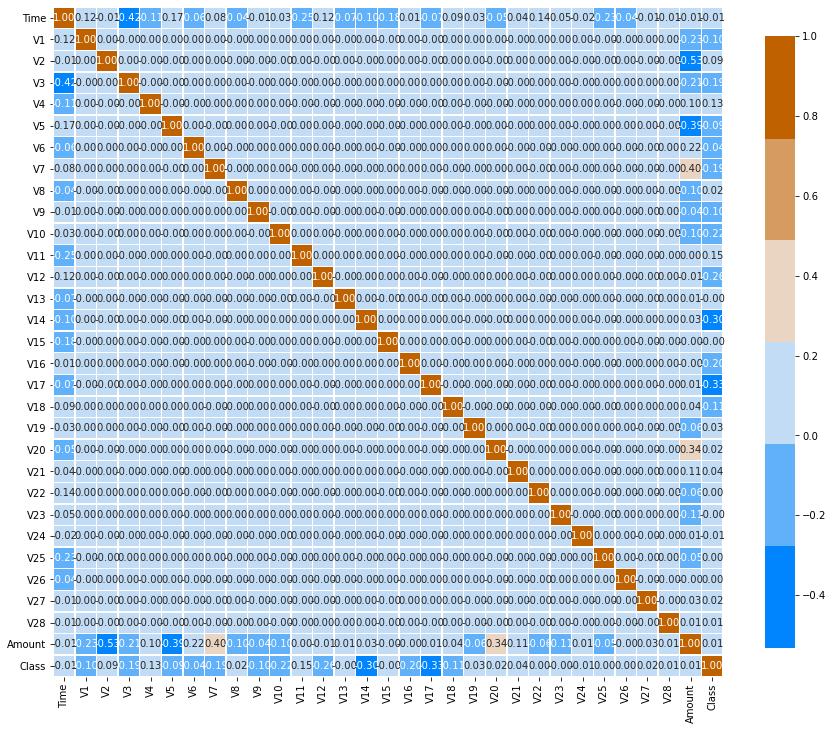

In [16]:
def plot_corr(data):
    plt.figure(figsize =(15,15))
    correlation = data.corr()
    cmap = sns.diverging_palette(250,50,250)
    sns.heatmap(correlation, cmap = cmap, annot = True, fmt = '.2f', square=True, linewidths='.5', cbar_kws={'shrink' : 0.75})
    plt.show()
plot_corr(df)

Class와 상관관계가 높은 V14, V17의 Outlier를 제거하도록 한다.

<b> Outlier index 반환 </b>

In [17]:
def get_outlier(df = None, column = None, weight = 1.5):
    # Fraud에 해당하는 columns 데이터만 추출, Q1, Q3 지점을 np.percentile로 구함.
    fraud = df[df['Class'] == 1][column]
    Q1 = np.percentile(fraud.values, 25)
    Q3 = np.percentile(fraud.values, 75)
    
    # Outlier를 구함
    IQR = Q3 - Q1
    IQR_weight = IQR * weight
    lowest_val = Q1 - IQR_weight
    highest_val = Q3 + IQR_weight
    
    # Max보다 크거나, Min보다 작은 값을 Outlier로 설정
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [18]:
outlier_index = get_outlier(df = df, column = 'V14', weight = 1.5)
print('Outlier index: ', outlier_index)

Outlier index:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [19]:
def get_preprocessed(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop('Time', axis = 1, inplace = True)
    
    # Del Outlier
    outlier_index = get_outlier(df = df_copy, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('### Logistic Regression ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print(' ### LightGBM ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves= 64, n_jobs =-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### Logistic Regression ###
Confusion Matrix
[[85282    13]
 [   47    99]]
accuracy :  0.9993, precision :  0.8839, recall :  0.6781,  F1 :  0.7674, AUC :  0.9609
 ### LightGBM ###
Confusion Matrix
[[85290     5]
 [   25   121]]
accuracy :  0.9996, precision :  0.9603, recall :  0.8288,  F1 :  0.8897, AUC :  0.9780


이상치 제거는 모델 성능에 좋은 것을 확인 할 수 있다.

## SMOTE Oversampling

In [20]:
smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전, 학습용 피처/레이블 데이터: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후, 학습용 피처/레이블 데이터: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전, 학습용 피처/레이블 데이터:  (199362, 30) (199362,)
SMOTE 적용 후, 학습용 피처/레이블 데이터:  (398040, 30) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


SMOTE 기법을 통해 불균형한 target을 균형적으로 처리함.

In [21]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test=X_test, tgt_train = y_train_over, tgt_test=y_test)

Confusion Matrix
[[82928  2367]
 [   12   134]]
accuracy :  0.9722, precision :  0.0536, recall :  0.9178,  F1 :  0.1012, AUC :  0.9715


recall이 상승했음.

### Precision Recall Trade-off Plot

In [22]:
def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

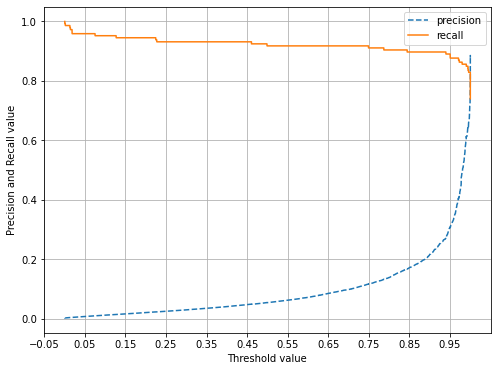

In [23]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [24]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves= 64, n_jobs =-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

Confusion Matrix
[[85284    11]
 [   24   122]]
accuracy :  0.9996, precision :  0.9173, recall :  0.8356,  F1 :  0.8746, AUC :  0.9814


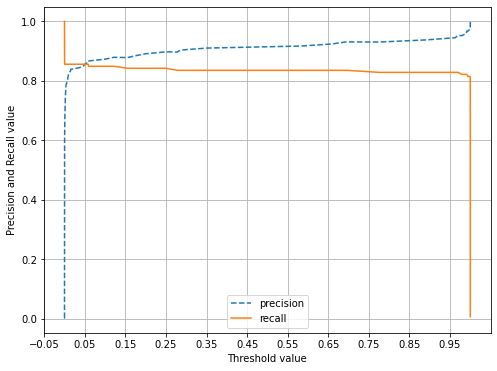

In [25]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:, 1])